Assignment Part 1- Tools + LLM

In [ ]:
import os
from huggingface_hub import InferenceClient

# Set your token here or as an environment variable
# os.environ["HF_TOKEN"] = ""
# use your own token by uncommenting above line

if not os.getenv("HF_TOKEN"):
    print("Please set your HF_TOKEN.")
    exit()

client = InferenceClient()

def main():
    audio_file = "path1audio.mp3"

    print("1. Transcribing (Whisper)...")
    # Using OpenAI Whisper via HF API
    # The InferenceClient expects the file path or raw bytes, not an open file object
    transcript = client.automatic_speech_recognition(
        audio_file, # Pass the file path string directly
        model="openai/whisper-large-v3-turbo"
    ).text
    print(f"Transcript: {transcript}")

    print("2. Refining (LLM)...")
    # Using Qwen 2.5 72B (Powerful open model)
    messages = [
        {"role": "system", "content": "Convert this audio transcript into a detailed stable diffusion prompt."},
        {"role": "user", "content": transcript}
    ]
    prompt = client.chat_completion(
        messages=messages,
        model="Qwen/Qwen2.5-72B-Instruct",
        max_tokens=100
    ).choices[0].message.content
    print(f"Prompt: {prompt}")

    print("3. Generating Image (FLUX)...")
    # Using FLUX.1-dev via HF API
    image = client.text_to_image(
        prompt,
        model="black-forest-labs/FLUX.1-dev"
    )
    image.save("flux_api_output.png")
    print("Done! Saved as flux_api_output.png")

if __name__ == "__main__":
    main()

1. Transcribing (Whisper)...
Transcript:  I found that nothing in life is worthwhile unless you take risks. Nothing. Nelson Mandela said, there is no passion to be found playing small and settling for a life that's less than the one you're capable of living. Now I'm sure in your experiences in school and applying to college and picking your major and deciding what you want to do with life, I'm sure people have told you to make sure you have something to fall back on. Make sure you got something to fall back on, honey. But I never understood that concept, having something to fall back on. If I'm going to fall, I don't want to fall back on anything.
2. Refining (LLM)...
Prompt: **Stable Diffusion Prompt:**

Create an image that captures the essence of taking risks and embracing a life full of passion and purpose, inspired by the words of Nelson Mandela and the speaker's perspective. The scene should feature a young person standing at the edge of a cliff, looking out into a vast, breathta

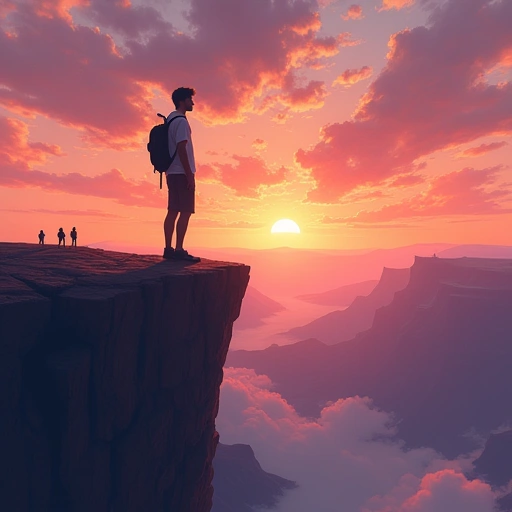

In [25]:
from PIL import Image

image = Image.open("flux_api_output.png")
display(image)

LLM + Adapter

In [ ]:
import os
import requests
import base64
import time
from io import BytesIO
from PIL import Image
from huggingface_hub import InferenceClient

# --- CONFIGURATION ---
# 1. Get token: https://huggingface.co/settings/tokens
HF_TOKEN = os.environ.get("HF_TOKEN")
if not HF_TOKEN:
    print("❌ Error: HF_TOKEN not found. Please ensure it's set in the environment or in the first cell.")
    exit(1)

# Initialize InferenceClient (used for LLM and image generation)
client = InferenceClient(token=HF_TOKEN)

API_BASE = "https://api-inference.huggingface.co/models"
HEADERS = {"Authorization": f"Bearer {HF_TOKEN}"}

def resize_image_for_api(image_path):
    """
    Resizes image to 512px to ensure the API processes it quickly
    without 'Payload Too Large' or timeout errors.
    """
    try:
        with Image.open(image_path) as img:
            img = img.convert("RGB")
            # Resize: limit longest side to 512px
            img.thumbnail((512, 512))

            buffered = BytesIO()
            img.save(buffered, format="JPEG", quality=80)
            return buffered.getvalue() # Returns raw bytes
    except Exception as e:
        print(f"❌ Error resizing image: {e}")
        return None

def query_huggingface_vision(model_id, image_bytes):
    """
    Sends a raw request to the Inference API for vision models.
    """
    url = f"{API_BASE}/{model_id}"

    for i in range(3):
        try:
            response = requests.post(url, headers=HEADERS, data=image_bytes)

            if response.status_code == 200:
                return response.json()
            elif response.status_code == 503:
                wait_time = response.json().get('estimated_time', 10)
                print(f"   ⏳ Model {model_id} loading... waiting {wait_time:.1f}s")
                time.sleep(wait_time)
                continue
            else:
                print(f"   ⚠️ API Error {response.status_code} for {model_id}:")
                print(f"      {response.text[:200]}...")
                return None

        except Exception as e:
            print(f"   ⚠️ Connection Error: {e}")
            return None
    return None

def step_1_vision(image_bytes):
    """
    Path 2 (Left): Image Encoder.
    Using BLIP via direct requests for better control.
    """
    print("👁️ [1/3] Scanning Image (BLIP)...")

    try:
        output = query_huggingface_vision(
            "nlpconnect/vit-gpt2-image-captioning",
            image_bytes
        )

        if output and isinstance(output, list) and "generated_text" in output[0]:
            description = output[0]['generated_text']
            print(f"   ↳ AI sees: \"{description}\"")
            return description
        else:
            print(f"   ❌ Unexpected response format from vision model: {output}")
            return None

    except Exception as e:
        print(f"   ❌ Error in Vision step: {e}")
        print(f"   ❌ Type of exception: {type(e)}")
        print(f"   ❌ Repr of exception: {repr(e)}")
        return None

def step_2_logic(vision_text, user_instruction):
    """
    Path 2 (Middle): LLM logic.
    Using Qwen 2.5 72B via InferenceClient.
    """
    print("🧠 [2/3] Refining Prompt (Qwen LLM)...")

    messages = [
        {"role": "system", "content": "You are a helpful assistant that generates detailed Stable Diffusion prompts."}, # Added system message for better LLM context
        {"role": "user", "content": f"Context: I have an image described as '{vision_text}'. Goal: {user_instruction}. Task: Write a detailed FLUX image generation prompt to achieve this goal. Output ONLY the prompt text, no pleasantries."
        }
    ]

    try:
        # Using InferenceClient.chat_completion
        response = client.chat_completion(
            messages=messages,
            model="Qwen/Qwen2.5-72B-Instruct",
            max_tokens=150
        )
        refined_prompt = response.choices[0].message.content.strip()
        print(f"   ↳ Prompt: \"{refined_prompt}\"")
        return refined_prompt
    except Exception as e:
        print(f"   ❌ Error in Logic step: {e}")
        return None

def step_3_generation(prompt):
    """
    Path 2 (Right): Image Decoder.
    Using FLUX.1-schnell via InferenceClient.
    """
    print("🎨 [3/3] Generating Image (FLUX)...")

    try:
        # Using InferenceClient.text_to_image
        image = client.text_to_image(
            prompt,
            model="black-forest-labs/FLUX.1-schnell"
        )
        image.save("path2_result.png")
        print("   ✅ SUCCESS! Image saved to 'path2_result.png'")
    except Exception as e:
        print(f"   ❌ Image Generation Failed: {e}")
        if "403 Client Error" in str(e) or "You need to accept terms" in str(e):
             print("      👉 You need to accept terms at: https://huggingface.co/black-forest-labs/FLUX.1-schnell")
        return None

def main():
    # SETUP
    input_file = "input_image.jpg"
    instruction = "Make it look like a sketch from the 1800s, vintage paper style."

    if not os.path.exists(input_file):
        print(f"❌ Input file '{input_file}' not found.")
        return

    # EXECUTION
    # 1. Prepare Image
    img_bytes = resize_image_for_api(input_file)
    if not img_bytes: return

    # 2. Vision
    vision_desc = step_1_vision(img_bytes)
    if not vision_desc:
        print("❌ Pipeline stopped at Vision step.")
        return

    # 3. Logic
    final_prompt = step_2_logic(vision_desc, instruction)
    if not final_prompt:
        print("❌ Pipeline stopped at Logic step.")
        return

    # 4. Generation
    step_3_generation(final_prompt)

if __name__ == "__main__":
    main()

Unified Model

In [ ]:
import os
from huggingface_hub import InferenceClient

# =====================================================
# 🔑 PASTE YOUR TOKEN HERE (Keep the quotes!)
# =====================================================
# HF_TOKEN = ""
# use own hf token
# =====================================================

def main():
    # 1. Validation
    if "hf_xxxx" in HF_TOKEN:
        print("❌ ERROR: You forgot to paste your specific HF Token at the top of the script!")
        return

    image_path = "input_image.jpg"
    if not os.path.exists(image_path):
        print(f"❌ ERROR: File '{image_path}' not found. Please put an image in this folder.")
        return

    # 2. Setup Client
    # We use the client because it handles the messy image formatting for us.
    client = InferenceClient(token=HF_TOKEN)

    print("🤖 Path 3: Unified Model (ViLT) is thinking...")

    try:
        # 3. Use the helper method 'visual_question_answering'
        # This AUTOMATICALLY formats the image correctly for the API.
        # We use 'dandelin/vilt-b32-finetuned-vqa' which is a Unified Model.

        answer = client.visual_question_answering(
            image=image_path,  # Passing the filename directly
            question="What are the main objects in this image?",
            model="dandelin/vilt-b32-finetuned-vqa"
        )

        # 4. Print Results
        # The API returns a list of possible answers with confidence scores
        print("\n✅ The Unified Model says:")
        for option in answer[:3]: # Print top 3 predictions
            print(f"   - {option.answer} (Confidence: {option.score:.1%})")

    except Exception as e:
        print(f"\n❌ Error Details: {e}")
        if "401" in str(e):
            print("   👉 Your Token is invalid. Check for spaces or typos.")
        elif "503" in str(e):
            print("   👉 The model is 'sleeping'. Wait 20 seconds and run this script again.")

if __name__ == "__main__":
    main()